In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

sns.set()

In [2]:
base = "https://raw.githubusercontent.com/pathstream-curriculum/Python/master/"
retail_features = "retail_features_4stores.csv"
retail_sales = "retail_sales_4stores.csv"

In [3]:
retail_sales_df = pd.read_csv(base + retail_sales)
retail_features_df = pd.read_csv(base + retail_features)

In [4]:
# convert Date to datetime
retail_sales_df["Date"] = pd.to_datetime(retail_sales_df.Date)
retail_features_df["Date"] = pd.to_datetime(retail_sales_df.Date)
# convert Store and Dept to string
retail_sales_df["Store"] = retail_sales_df.Store.astype("str")
retail_sales_df["Dept"] = retail_sales_df.Dept.astype("str")
retail_features_df["Store"] = retail_features_df.Store.astype("str")

#deal with the sorting issue up front
retail_sales_df.sort_values("Date", inplace=True)
retail_features_df.sort_values("Date", inplace=True)

In [5]:
retail_sales_df.head()

,Unnamed: 0,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1178,Los Angeles,Clothing,2010-01-10,27023.35,False
31,2751,Buffalo,Jewelry,2010-01-10,6947.26,False
30,1464,Los Angeles,Furniture,2010-01-10,12390.87,False
29,3609,Seattle,Housewares,2010-01-10,88537.23,False
28,463,Las Vegas,Jewelry,2010-01-10,34912.45,False


## Narrative -- the stores run promotions a few times a year. Your job is to determine
a) if promotion weeks lead to greater total sales in dollars than non-promotion weeks
b) if promotion weeks lead to a greater number of visitors to the store
c) if promotion weeks lead to a greater proportion of people making purchases

internal note: we could actually make an interesting case study that finds that customer numbers are increased, proportions are decreased, and sales are...up? down?

In [6]:
# total sales DF 
total_sales = retail_sales_df.groupby(["Store", "Date"]).agg({"Weekly_Sales":"sum"}).reset_index()

In [7]:
total_sales

,Store,Date,Weekly_Sales
0,Buffalo,2010-01-10,53827.15
1,Buffalo,2010-02-04,72078.00
2,Buffalo,2010-02-07,57671.21
3,Buffalo,2010-02-19,70042.38
4,Buffalo,2010-02-26,62925.05
...,...,...,...
567,Seattle,2012-10-08,387550.68
568,Seattle,2012-10-19,374977.90
569,Seattle,2012-10-26,382662.25
570,Seattle,2012-11-05,342123.40


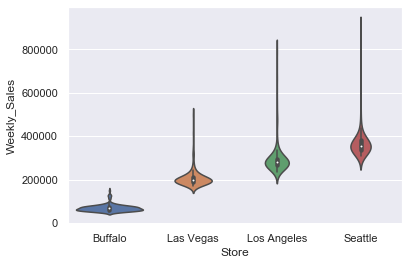

In [8]:
sns.violinplot(data=total_sales, x="Store", y="Weekly_Sales")

In [9]:
# let's just do Seattle
total_sales_sea = total_sales.loc[total_sales["Store"]=="Seattle"
                            ].loc[total_sales["Date"]>pd.to_datetime('6/30/10')
                            ].loc[total_sales["Date"]<pd.to_datetime('7/1/12')]

total_sales_sea.reset_index(inplace=True)

In [10]:
total_sales_sea_by_ws = total_sales_sea.sort_values("Weekly_Sales", ascending=False)

In [11]:
s1 = np.random.choice(total_sales_sea_by_ws.Date[:30], 12)
s2 = np.random.choice(total_sales_sea_by_ws.Date[30:60], 10)
s3 = np.random.choice(total_sales_sea_by_ws.Date[60:], 9)
promo_dates = pd.Series(np.concatenate((s1, s2, s3)))
non_promo_dates = np.setdiff1d(total_sales_sea_by_ws.Date, promo_dates)

In [12]:
promo_sea = total_sales_sea_by_ws.loc[total_sales_sea_by_ws["Date"].isin(promo_dates)]
non_promo_sea = total_sales_sea_by_ws.loc[total_sales_sea_by_ws["Date"].isin(non_promo_dates)]

In [13]:
promo_sea


,index,Store,Date,Weekly_Sales
75,526,Seattle,2011-12-16,641924.61
98,549,Seattle,2012-06-04,451403.30
40,491,Seattle,2011-04-11,433583.79
68,519,Seattle,2011-10-28,397699.44
5,456,Seattle,2010-08-13,391208.18
6,457,Seattle,2010-08-20,385092.46
94,545,Seattle,2012-05-10,384091.19
82,533,Seattle,2012-02-03,381636.54
84,535,Seattle,2012-02-24,380841.41
77,528,Seattle,2011-12-30,380439.25


In [14]:
ave_promo_spend = 200
ave_non_promo_spend = 210

sd = 20

promo_spends = np.random.normal(ave_promo_spend, sd, len(promo_sea)).round(2)
non_promo_spends = np.random.normal(ave_non_promo_spend, sd, len(non_promo_sea)).round(2)

In [60]:
non_paying_promo = np.random.normal(1500, 400, size=len(promo_spends))
promo_sea["Num_Customers"] = ((promo_sea.Weekly_Sales / promo_spends).round().astype(int) + 
                              non_paying_promo).astype(int)

/Users/caldermyers/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [61]:
non_paying_non_promo = np.random.normal(1400, 400, size=len(non_promo_spends))

non_promo_sea["Num_Customers"] = ((non_promo_sea.Weekly_Sales / non_promo_spends).round().astype(int) + 
                                  non_paying_non_promo).astype(int)


/Users/caldermyers/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [86]:
promo_sea["Promo_Week"] = True
non_promo_sea["Promo_Week"] = False

promo_sea["Num_Sales"] = (promo_sea.Num_Customers - non_paying_promo).astype(int)
non_promo_sea["Num_Sales"] = (non_promo_sea.Num_Customers - non_paying_non_promo).astype(int) + 25

promo_sea["Num_Customers"] = promo_sea.Num_Customers + 10

/Users/caldermyers/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/caldermyers/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/caldermyers/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [87]:
retail_promotions_df = pd.concat([promo_sea, non_promo_sea]).reset_index(drop=True).sort_values("Date")

In [88]:
retail_promotions_df.drop(retail_promotions_df.columns[0], axis=1, inplace=True)
retail_promotions_df["Num_Visitors"] = retail_promotions_df.Num_Customers

In [89]:
retail_promotions_df

,Store,Date,Weekly_Sales,Num_Customers,Promo_Week,Num_Sales,Num_Visitors
84,Seattle,2010-07-05,335237.34,3200,False,1511,3200
89,Seattle,2010-07-16,330525.74,2991,False,1692,2991
96,Seattle,2010-07-23,323996.64,2927,False,1548,2927
19,Seattle,2010-07-30,344366.33,2727,True,1879,2727
73,Seattle,2010-08-10,345812.75,2806,False,1532,2806
...,...,...,...,...,...,...,...
1,Seattle,2012-06-04,451403.30,3895,True,2143,3895
12,Seattle,2012-06-07,368294.20,3448,True,1885,3448
15,Seattle,2012-06-15,364960.21,3283,True,1852,3283
62,Seattle,2012-06-22,355789.41,3776,False,1962,3776


In [90]:
retail_promotions_df = retail_promotions_df[["Store", "Date", "Num_Visitors", "Num_Sales", "Weekly_Sales", "Promo_Week"]]

In [91]:
retail_promotions_df

,Store,Date,Num_Visitors,Num_Sales,Weekly_Sales,Promo_Week
84,Seattle,2010-07-05,3200,1511,335237.34,False
89,Seattle,2010-07-16,2991,1692,330525.74,False
96,Seattle,2010-07-23,2927,1548,323996.64,False
19,Seattle,2010-07-30,2727,1879,344366.33,True
73,Seattle,2010-08-10,2806,1532,345812.75,False
...,...,...,...,...,...,...
1,Seattle,2012-06-04,3895,2143,451403.30,True
12,Seattle,2012-06-07,3448,1885,368294.20,True
15,Seattle,2012-06-15,3283,1852,364960.21,True
62,Seattle,2012-06-22,3776,1962,355789.41,False


In [92]:
retail_promotions_df["Num_Visitors"] = retail_promotions_df.Num_Visitors + 10

/Users/caldermyers/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [93]:
retail_promotions_df.to_csv('retail_promotions_seattle_03.csv', index=False)

## Intermediate tweaking

In [105]:
df = pd.read_csv('retail_promotions_seattle_01.csv')

In [106]:
np = df.loc[df.Promo_Week == True]
p = df.loc[df.Promo_Week == False]


In [107]:
p["Num_Visitors"] = p["Num_Visitors"] - 20

/Users/caldermyers/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [108]:
df = pd.concat([np, p])

In [109]:
df.to_csv('retail_promotions_seattle_04.csv', index=False)

In [104]:
sum(df.Num_Visitors)

343463

# What will this look like from the beginning?

In [141]:
seattle_promos_df = pd.read_csv('retail_promotions_seattle.csv')

In [142]:
seattle_promos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 6 columns):
Store           103 non-null object
Date            103 non-null object
Num_Visitors    103 non-null int64
Num_Sales       103 non-null int64
Weekly_Sales    103 non-null float64
Promo_Week      103 non-null bool
dtypes: bool(1), float64(1), int64(2), object(2)
memory usage: 4.2+ KB


In [143]:
seattle_promos_df["Date"] = pd.to_datetime(seattle_promos_df.Date)

In [144]:
seattle_promos_df.head()

,Store,Date,Num_Visitors,Num_Sales,Weekly_Sales,Promo_Week
0,Seattle,2010-07-05,3256,1573,335237.34,False
1,Seattle,2010-07-16,2703,1750,330525.74,False
2,Seattle,2010-07-23,2917,1595,323996.64,False
3,Seattle,2010-07-30,3317,1973,344366.33,False
4,Seattle,2010-08-10,3144,1567,345812.75,False


Text(0.5, 0.98, 'Seattle Store Visitors')

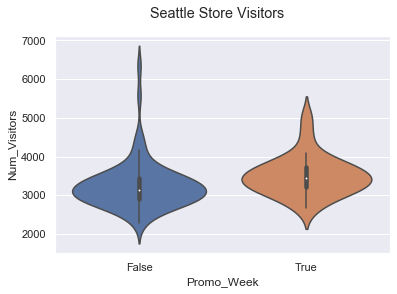

In [145]:
fig = plt.figure()
sns.violinplot(data=seattle_promos_df, x="Promo_Week", y="Num_Visitors")
fig.suptitle("Seattle Store Visitors") 

In [146]:
promo_week_visitors = seattle_promos_df.loc[seattle_promos_df["Promo_Week"]==True]["Num_Visitors"]
non_promo_week_visitors = seattle_promos_df.loc[seattle_promos_df["Promo_Week"]==False]["Num_Visitors"]
ttest_ind(promo_week_visitors, non_promo_week_visitors, alternative='larger')

(1.911110552795885, 0.029412772143431368, 101.0)

Text(0.5, 0.98, 'Seattle Store Weekly Sales')

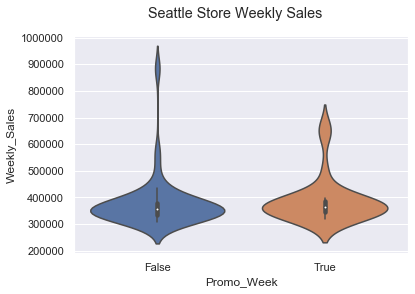

In [147]:
fig = plt.figure()
sns.violinplot(data=seattle_promos_df, x="Promo_Week", y="Weekly_Sales")
fig.suptitle("Seattle Store Weekly Sales") 

In [150]:
promo_week_sales = seattle_promos_df.loc[seattle_promos_df["Promo_Week"]==True]["Weekly_Sales"]
non_promo_week_sales = seattle_promos_df.loc[seattle_promos_df["Promo_Week"]==False]["Weekly_Sales"]
ttest_ind(promo_week_sales, non_promo_week_sales, alternative='larger')

(0.4740521212260502, 0.31824297996716727, 101.0)

Hypothesis Tests

1. Is there a significant difference between the number of customers in promotion weeks vs. non promotions weeks?
2. Is there a significant difference in weekly sales between promotion weeks and non-promotions weeks? 

In [316]:
promo_weekly_sales = seattle_promos_df.loc[seattle_promos_df["Promo_Week"]==True]["Weekly_Sales"]
non_promo_weekly_sales = seattle_promos_df.loc[seattle_promos_df["Promo_Week"]==False]["Weekly_Sales"]

In [384]:
t, p = stats.ttest_ind(promo_weekly_sales, non_promo_weekly_sales)
t, p

(1.179189736718877, 0.24109295152741528)

In [318]:
promo_num_customers = seattle_promos_df.loc[seattle_promos_df["Promo_Week"]]["Num_Customers"]
non_promo_num_customers = seattle_promos_df.loc[~seattle_promos_df["Promo_Week"]]["Num_Customers"]

In [319]:
stats.ttest_ind(promo_num_customers, non_promo_num_customers)

Ttest_indResult(statistic=2.1383474843851635, pvalue=0.03490034014357477)

In [189]:
promo_customer = np.random.normal(50000, 10000, len(promo_dates)).round()
non_promo_customer = np.random.normal(40000, 10000, len(non_promo_dates)).round()

In [166]:
promo_dates = pd.Series(promo_dates)

In [167]:
promo_df = pd.DataFrame(promo_dates)
promo_df.columns = ["Date"]
promo_df["Num_Customers"] = promo_customer
promo_df["Promo_Week"] = True
promo_df.head()

,Date,Num_Customers,Promo_Week
0,2011-04-22,39268.0,True
1,2010-12-02,43672.0,True
2,2012-02-17,51041.0,True
3,2011-12-23,41446.0,True
4,2012-03-08,37951.0,True


In [168]:
non_promo_df = pd.DataFrame(non_promo_dates)
non_promo_df.columns = ["Date"]
non_promo_df["Num_Customers"] = non_promo_customer
non_promo_df["Promo_Week"] = False
non_promo_df.head()

,Date,Num_Customers,Promo_Week
0,2010-07-05,37647.0,False
1,2010-07-16,34394.0,False
2,2010-07-23,47635.0,False
3,2010-07-30,38691.0,False
4,2010-08-10,46892.0,False


In [169]:
promotions_df = pd.concat([promo_df, non_promo_df]).sort_values("Date").reset_index(drop=True)
promotions_df.head()

,Date,Num_Customers,Promo_Week
0,2010-07-05,37647.0,False
1,2010-07-16,34394.0,False
2,2010-07-23,47635.0,False
3,2010-07-30,38691.0,False
4,2010-08-10,46892.0,False


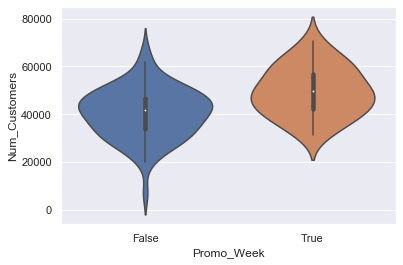

In [170]:
sns.violinplot(data=promotions_df, x="Promo_Week", y="Num_Customers")

Further adjustments -- let's determine the number of customers by how much the average customer spends. 

In [171]:
ave_promo_spend = 220
ave_non_promo_spend = 200
sd = 20

promo_spends = np.random.normal(ave_promo_spend, sd, len(promo_dates)).round(2)
non_promo_spends = np.random.normal(ave_non_promo_spend, sd, len(non_promo_dates)).round(2)

In [ ]:
promo_customers = 

## Experiments: Is there a significant difference in weekly [dept] sales between the Seattle and Los Angeles stores? 

Null hypothesis: There is no significant difference between the mean weekly [dept] sales at the Seattle store and the Los Angeles store
Alternative hypothesis: There is a significant difference between the mean weekly [dept] sales at the Seattle store and the Los Angeles store

In [54]:
# filter the DataFrames to dept+SEA and +LA. Remove data from 01/10/2012 and later so that we
# have exactly 2 years of data (currently runs from 01/10/10 to 12/10/12)
seattle_df = retail_sales_df.loc[(retail_sales_df["Store"]=="Seattle") &
                                   (retail_sales_df["Date"]<pd.to_datetime('01-10-2012'))]

la_df = retail_sales_df.loc[(retail_sales_df["Store"]=="Los Angeles") &
                                   (retail_sales_df["Date"]<pd.to_datetime('01-10-2012'))]

In [56]:
def run_ttest(df1, df2, dept, sample_size):
    df1_filt = df1.loc[df1["Dept"]==dept]
    df2_filt = df2.loc[df2["Dept"]==dept]
    
    df1_samp = df1_filt["Weekly_Sales"].sample(sample_size)
    df2_samp = df2_filt["Weekly_Sales"].sample(sample_size)
    
    return stats.ttest_ind(df1_samp, df2_samp)

In [85]:
np.random.seed(42)
for d in retail_sales_df.Dept.unique():
    for _ in range(20):
        ct=0
        type_2 = p
        t, p = run_ttest(seattle_df, seattle_df, d, 15)
        if p>0.05:
            type_2+=1
        ct+=1
    print(type_2/ct)
    print ('')


Clothing 0.7002085115918866
Clothing 0.3888488019826687
Clothing 0.17611779983708672
Clothing 0.9350832671341154
Clothing 0.27893839540493925
Clothing 0.5699383016945279
Clothing 0.3815292519699913
Clothing 0.05130017209141377
Clothing 0.23397998791962338
Clothing 0.6479633274163131
Clothing 0.5732967721037519
Clothing 0.3876419581393781
Clothing 0.9929541529375818
Clothing 0.7100002575376134
Clothing 0.7169650836615686
Clothing 0.7080763460650036
Clothing 0.43053938212094633
Clothing 0.9364615986050312
Clothing 0.36844025929000246
Clothing 0.6911775241639968

Jewelry 0.8823627382170167
Jewelry 0.432293641428353
Jewelry 0.015163584248405049
Jewelry 0.12977336904009074
Jewelry 0.423803304037047
Jewelry 0.6963158075580149
Jewelry 0.9351025093542185
Jewelry 0.5195737819480502
Jewelry 0.20474179038381968
Jewelry 0.7591342088254729
Jewelry 0.6329346628745207
Jewelry 0.7853117635912665
Jewelry 0.811204040124401
Jewelry 0.4192783780296714
Jewelry 0.9453599957460014
Jewelry 0.02631542132733380

In [81]:
np.random.seed(24)
for d in retail_sales_df.Dept.unique():
    print(d, run_ttest(seattle_df, la_df, d, 100))
    print ('')


Clothing Ttest_indResult(statistic=2.6947375146537365, pvalue=0.007649758398722231)

Jewelry Ttest_indResult(statistic=16.69696101305176, pvalue=1.2124321701359798e-39)

Furniture Ttest_indResult(statistic=0.5754627663808601, pvalue=0.5656317744065542)

Housewares Ttest_indResult(statistic=26.28868783176826, pvalue=1.7026460203775324e-66)

Outdoor Ttest_indResult(statistic=1.5620813847811597, pvalue=0.11986569874602397)

Shoes Ttest_indResult(statistic=1.5431563912838213, pvalue=0.12438955758875092)

Toys Ttest_indResult(statistic=8.901569456519466, pvalue=3.525261268238593e-16)

Electronics Ttest_indResult(statistic=4.6686342480382725, pvalue=5.582885266023108e-06)



In [98]:
cts = []
for i in range(20):
    ct=0
    for j in range(20):
        t, p = run_ttest(seattle_df, seattle_df, d, 15)
        if p<0.05:
            ct+=1
    cts.append(ct)

print(cts)
print ('')

[0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1]



In [44]:
# now take a sample of 15 data points from each of the "weekly_sales" columns
np.random.seed(2)
sea_sample = seattle_shoes["Weekly_Sales"].sample(30)
la_sample = la_shoes["Weekly_Sales"].sample(30)

In [45]:
sea_sample

2526     41452.87
988      34195.53
1853     64586.72
771      35512.50
525      31165.85
767      38298.54
65       49861.13
895      35877.79
917      30029.99
439      37239.25
1922     31963.41
3002     57751.03
2470     36373.80
468      35442.76
25       32910.99
688      47916.68
99       35309.25
931      36913.10
3229     76274.69
1774     45109.70
1142    121861.67
379      32030.76
2854     49930.58
1415     45522.98
2272     58892.12
183      37396.86
818      33527.62
2087     40734.59
1704     39017.49
2587     29304.64
Name: Weekly_Sales, dtype: float64

In [46]:
la_sample

800      25195.42
1433     42628.64
3113    138188.63
331      29678.87
1077     26189.63
2123     25814.41
2168     31771.61
2073     36955.68
2967     26636.69
1801     31330.01
929      25264.69
972      32545.60
145      24275.91
416      28512.95
2506     30127.42
3196     56063.19
1950     22120.83
1134    140504.01
2720     23498.80
770      30319.88
757      28685.54
2915     28913.34
223      94720.59
411      29456.07
1244     27622.15
602      51582.43
2388     25582.86
1980     30314.48
2465     24296.94
87       34611.91
Name: Weekly_Sales, dtype: float64

In [47]:
stats.ttest_ind(sea_sample, la_sample)

Ttest_indResult(statistic=0.6124689103625115, pvalue=0.5426214846108114)

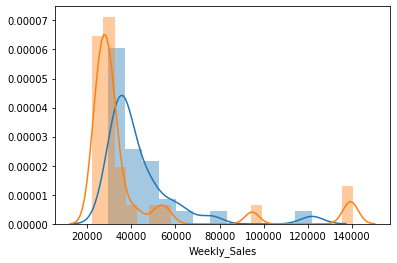

In [48]:
sns.distplot(sea_sample)
sns.distplot(la_sample)

In [49]:
# filter the DataFrames to shoes+SEA and shoes+LA. Remove data from 01/10/2012 and later so that we
# have exactly 2 years of data (currently runs from 01/10/10 to 12/10/12)
seattle_jewelry = retail_sales_df.loc[(retail_sales_df["Store"]=="Seattle") &
                                   (retail_sales_df["Dept"]=="Jewelry") &
                                   (retail_sales_df["Date"]<pd.to_datetime('01-10-2012'))]

la_jewelry = retail_sales_df.loc[(retail_sales_df["Store"]=="Los Angeles") &
                                   (retail_sales_df["Dept"]=="Jewelry") &
                                   (retail_sales_df["Date"]<pd.to_datetime('01-10-2012'))]

In [52]:
# now take a sample of 15 data points from each of the "weekly_sales" columns
np.random.seed(2)
sea_sample = seattle_jewelry["Weekly_Sales"].sample(30)
la_sample = la_jewelry["Weekly_Sales"].sample(30)

In [53]:
stats.ttest_ind(sea_sample, la_sample)

Ttest_indResult(statistic=12.302309616702798, pvalue=8.324444213168664e-18)

In [ ]:
def run_ttest(df1, df2, dept):
    
    

In [9]:
retail_sales_elec = retail_sales_df.loc[retail_sales_df["Dept"] == "Electronics"]

(array([252., 218.,  71.,  14.,   5.,   5.,   2.,   3.,   1.,   1.]),
 array([  4730.87 ,  21750.036,  38769.202,  55788.368,  72807.534,
         89826.7  , 106845.866, 123865.032, 140884.198, 157903.364,
        174922.53 ]),
 <a list of 10 Patch objects>)

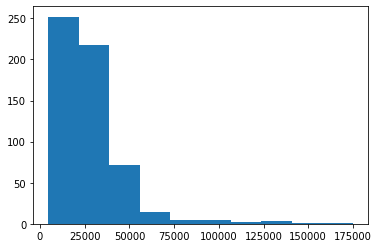

In [10]:
plt.hist(retail_sales_elec["Weekly_Sales"])

In [13]:
retail_sales_elec.sort_values("Weekly_Sales", ascending=False)

,Unnamed: 0,Store,Dept,Date,Weekly_Sales,IsHoliday
1476,4050,Seattle,Electronics,2010-12-24,174922.53,False
1475,1762,Los Angeles,Electronics,2010-12-24,150343.42,False
3148,4102,Seattle,Electronics,2011-12-23,140165.76,False
1333,4046,Seattle,Electronics,2010-11-26,129860.88,True
3048,4098,Seattle,Electronics,2011-11-25,125098.69,True
...,...,...,...,...,...,...
756,2883,Buffalo,Electronics,2010-07-16,5274.61,False
567,2875,Buffalo,Electronics,2010-05-21,5079.98,False
954,2889,Buffalo,Electronics,2010-08-27,4945.21,False
167,2890,Buffalo,Electronics,2010-03-09,4862.58,False


In [14]:
retail_sales_elec_la = retail_sales_elec.loc[retail_sales_elec["Store"] == "Los Angeles"]

In [17]:
retail_sales_elec_la.sort_values("Weekly_Sales", ascending=False)[:20]

,Unnamed: 0,Store,Dept,Date,Weekly_Sales,IsHoliday
1475,1762,Los Angeles,Electronics,2010-12-24,150343.42,False
3137,1814,Los Angeles,Electronics,2011-12-23,106536.90,False
1324,1758,Los Angeles,Electronics,2010-11-26,102750.26,True
3069,1810,Los Angeles,Electronics,2011-11-25,102614.71,True
1465,1761,Los Angeles,Electronics,2010-12-17,90724.19,False
1128,1760,Los Angeles,Electronics,2010-10-12,76143.28,False
3129,1813,Los Angeles,Electronics,2011-12-16,65588.98,False
3372,1822,Los Angeles,Electronics,2012-02-17,52735.59,False
281,1723,Los Angeles,Electronics,2010-03-26,51778.35,False
2679,1812,Los Angeles,Electronics,2011-09-12,51509.07,False


In [18]:
len(retail_sales_elec_la)

143

In [ ]:
# 15 from the first 50, 10 from the next 50, 5 from the last few

In [22]:
s1 = np.random.choice(retail_sales_elec_la.index[:50], 15)
s2 = np.random.choice(retail_sales_elec_la.index[50:100], 10)
s3 = np.random.choice(retail_sales_elec_la.index[100:], 5)

In [32]:
promo_indexes = pd.Series(np.concatenate((s1, s2, s3)))

In [30]:
thirty_trues

In [31]:
promo_indexes

AttributeError: 'numpy.ndarray' object has no attribute 'endswith'

AttributeError: 'numpy.ndarray' object has no attribute 'endswith'

In [32]:
retail_joined_df = retail_features_df.merge(retail_sales_df, on=["Store", "Date"])
retail_joined_df_jwl = retail_joined_df.loc[retail_joined_df["Dept"] == "Jewelry"]
retail_joined_df_jwl.drop("IsHoliday_y", axis=1, inplace=True)

/Users/caldermyers/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
